<center>
<h1>FORS2 Quality Control Script</h1>
<h3>Vicente De la Rosa Sánchez</h3>
<h3>Universidad Técnica Federico Santa María</h3>
<h3>Summer Students Chile ESO 2022 Internship Program</h3>
<img src="./Images/eso.png">
</center>

### 0. Libraries

In [1]:
from PythonPhot import aper
from PythonPhot import pkfit
import astropy.io.fits as pyfits
import astropy.coordinates as coord
import astropy.units as u
from astropy.wcs import WCS
from astropy.table import Table
from astroquery.vizier import Vizier
from astropy.stats import sigma_clip
import numpy as np
import numpy.ma as ma
import pandas as pd
import os
import math
from scipy.spatial import KDTree

# Warnings
import warnings
from astropy.io.fits.verify import VerifyWarning
warnings.simplefilter('ignore', category=VerifyWarning)

### 1. SExtractor

In [2]:
# Path of the image to be processed with Sextractor
#image = 'FORS2.2019-03-03T09_10_37.159.fits'
image = 'FORS2.2021-03-11T06_37_35.166.fits'

# Folder which contains the FORS2 files
fors2_folder = './FORS2Archives'
image_path = os.path.join(fors2_folder, image)

# Create a folder where the results of every image will be stored
results_folder = './results'

if not os.path.exists(results_folder):
    os.makedirs(results_folder)

# Write the file that contains the list of images
image_file = open('list_images.txt', 'w')
image_file.write(image_path[:-5])
image_file.close()

# Extract all the stars from the image using Sextractor
os.system('sex ' + image_path + ' -CATALOG_NAME ' + image[:-5] + '.sex2d.txt')

# Create the directory which will contain all the Sextractor related files with the name of the image
current_directory = os.getcwd()
image_directory = os.path.join(current_directory + '/results', r'{}'.format(image[:-5]))


> WARNING: NTHREADS != 1 ignored: this build of SExtractor is single-threaded

> 
----- SExtractor 2.19.5 started on 2022-03-22 at 11:13:18 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing catalog
> Looking for FORS2.2021-03-11T06_37_35.166.fits
----- Measuring from: FORS2.2021-03-11T06_37_35.166.fits
      "NGC5139" / no ext. header / 2048x1034 / 16 bits (integers)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line:  256
> Setting up background map at line:  320
> Setting up background map at line:  384
> Setting up background map at line:  448
> Setting up background map at line:  512
> Setting up background map at line:  576
> Setting up background map at line:  640
> Setting up background map at line:  704
> Setting up background map at line:  768
> Setting up background map at 

In [3]:
def create_valid_stars(image):
    # Create the directory which will contain all the Sextractor related files with the name of the image
    current_directory = os.getcwd()
    image_directory = os.path.join(current_directory + '/results', r'{}'.format(image[:-5]))

    if not os.path.exists(image_directory):
        os.makedirs(image_directory)

    # Number of valids stars and total stars
    valid_stars = 0
    total_stars = 0

    # File with valid stars (stars with flag value = 0)
    valids = open(image_directory + "/" + image[:-5] + '.sex2d.valid.txt', 'w')
    # Reg file with valid stars (for DS9)
    reg_valids = open(image_directory + '/' + image[:-5] + '.sex2d.valid.reg', 'w')

    # Open the file generated with Sextractor to obtain the non saturated stars
    with open(image[:-5]+'.sex2d.txt', 'r') as fi:
        for line in fi:
            line = line.split()
            parameters = len(line)
            if '#' not in line:
                total_stars += 1
                # If the flag value of the star is 0, then the star is valid, and we write it in the file and in the reg file
                if int(line[-1]) == 0:
                    # Write in the reg file 
                    reg_valids.write('image; circle '+line[0]+' '+line[1]+' 3 \n' )
                    # Write valid stars to file, with all the parameters except the flag value
                    valids.write(str(valid_stars)+' ')
                    # X and Y coordinates are always the first two parameters, all the rest are distinct
                    for i in range(parameters - 1):
                        valids.write(line[i]+ ' ')
                    valids.write('\n')
                    valid_stars += 1

    valids.close()
    reg_valids.close()

    return valid_stars, total_stars

In [4]:
valid_stars, total_stars = create_valid_stars(image)

print(f'Number of valid stars, i.e. stars with flag value 0: {valid_stars}')
print(f'Number of total stars: {total_stars}')
print(f'Percentage of valid stars: {valid_stars/total_stars*100}%')

Number of valid stars, i.e. stars with flag value 0: 1513
Number of total stars: 4178
Percentage of valid stars: 36.21349928195309%


In [5]:
valid_stars_table = Table.read(image_directory + '/' + image[:-5] + '.sex2d.valid.txt', format='ascii', delimiter=' ')

# Obtain the FWHM and ellipticity of the valid extracted stars
# 4th and 8th parameters in the Sextractor valid file are the ellipticity and the FWHM, respectively
valid_stars_table.rename_column('col4', 'ellipticity')
valid_stars_table.rename_column('col8', 'fwhm')

fwhm_sextractor = valid_stars_table['fwhm']
ellipticity_sextractor = valid_stars_table['ellipticity']

# Filter the 0 values of FWHM?
fwhm_sextractor = fwhm_sextractor[fwhm_sextractor != 0]

# Compute the average and median FWHM and ellipticity
average_fwhm_sextractor = np.mean(fwhm_sextractor)
median_fwhm_sextractor = np.median(fwhm_sextractor)
average_ellipticity_sextractor = np.mean(ellipticity_sextractor)
median_ellipticity_sextractor = np.median(ellipticity_sextractor)

In [6]:
print(f"Average FWHM: {average_fwhm_sextractor}")
print(f"Median FWHM: {median_fwhm_sextractor}")
print(f"Average ellipticity: {average_ellipticity_sextractor}")
print(f"Median ellipticity: {median_ellipticity_sextractor}")

Average FWHM: 3.854223397224058
Median FWHM: 3.15
Average ellipticity: 0.20226635822868472
Median ellipticity: 0.162


### 2. PSF fitting

In [7]:
# Import the auxiliary functions
import functions as pf

# Parameters to be set manually

# Name of the file which contains the images to be processed
list_images = 'list_images.txt'

# Name of the log file
log_file = "psfprogram.log"

# Path where to store the PSF models and the lists of stars
path_psf = './psfstore'
path_stars = './starstore'

#Radius (in arcmin) for the query of stars suitable for the PSF extraction
radius_search=3.5  #arcmin

#Do you want to calibrate to DECam magnitudes? (True/False)
#If True, then no calibration using catalogs will be performed.
calib_DECam=False

#Which catalog to extract the magnitude of the stars from? ('USNO-B1'/'GAIA')
#Note: this will not be active if calibDECam=True
catmag=None

#Range of F filter magnitudes (red) good to select stars
#suitable for the PSF extraction (basically, not too bright, not too faint)
mag_range=[16.5,19]

# Number of brightest stars to be used from the image to fit the PSF model
bright_stars = int(input("Insert the number of brightest stars to be used to fit the PSF model: "))
#-------------------------------
#Recentering during the PSF fitting? ("YES"/"NO")
recenter="YES"

#filter 'g'/'r' ('u','i','z','Y' only if calibDECam=True)
filter='g'

#Zero point: ()
zeropoint_value=27.531354844160536

#Rough value for the FWHM (in pixel)
fwhm_nominal=8.0  #pixel, mainly used to establish the distance of the source from the border.

#Maximum distance for coincident sources (radius, in arcsec)
radmatch=1.2

#Photons per ADU:
phpadu=2.4

#Readout noise per pixel (scalar)
ronois=4.9 #Rough re

In [8]:
# Read the list of coordinates obtained with sextractor for the given image, which flag values are 0 (i.e. not saturated stars)
stars_file = image_directory + "/" + image[:-5] + '.sex2d.valid.txt' 
stars_list = Table.read(stars_file, format='ascii', delimiter=' ')
# Rename all the columns to what they mean in Sextractor
stars_list.rename_column('col1','ID')
stars_list.rename_column('col2','X')
stars_list.rename_column('col3','Y')
stars_list.rename_column('col4','ellipticity')
stars_list.rename_column('col5', 'flux')
stars_list.rename_column('col6', 'fluxerr')
stars_list.rename_column('col7', 'mag')
stars_list.rename_column('col8', 'fwhm')

In [9]:
fwhm_psf = []
ellipticity_psf = []

# Get dimension of the image
data_image = pyfits.getdata(image_path)

x_dim = int(len(data_image[0]))
y_dim = int(len(data_image))

# Computing the FWHM and ellipticity of every star using PSF fitting
for i in range(valid_stars):
    star = stars_list[i]
    # Check that the star is located within acceptable values (not too close to the borders)
    checklocation = (star['X'] > 2.5*fwhm_nominal and star['X'] < (x_dim-2.5*fwhm_nominal) and  star['Y'] > 2.5*fwhm_nominal and star['Y'] < (y_dim-2.5*fwhm_nominal))
    if not checklocation:
        print(f"Star #{i} too close to the borders, skipping...")   
        continue
    # PSF of the image using a single star (star #i)
    gauss, psf_residuals, psfmag = pf.getPSFimage(data_image, image_path, star, star['X'], star['Y'], ronois, phpadu, individual=True, pathpsf=path_psf)
    
    # Error, no convergence for the star
    if np.array_equal(gauss, np.array([-1,-1,-1,-1,-1])):
        continue
    
    # Compute the FWHM
    sigma_star = np.mean([gauss[3], gauss[4]])
    fwhm_star = 2.355*sigma_star
    fwhm_psf.append(fwhm_star)

    # Obtain the header of the PSF model generated
    hpsf = pyfits.getheader(path_psf + '/' + image[:-5] + '_psf_residuals.fits')
    # Determine the semi major and semi minor axis to obtain the ellipticity
    direction_x = hpsf['GAUSS4']
    direction_y = hpsf['GAUSS5']

    ellipticity_star = 0.0

    # Compute the ellipticity using the sextractor formula (1 - (semiminor axis)/(semimajor axis))
    if direction_x >= direction_y:
        ellipticity_star = 1 - (direction_y)/(direction_x)
    else:
        ellipticity_star = 1 - (direction_x)/(direction_y)

    ellipticity_psf.append(ellipticity_star)

# Compute the average and median FWHM and ellipticity obtained with PSF fitting
average_fwhm_psf = np.mean(fwhm_psf)
median_fwhm_psf = np.median(fwhm_psf)
average_ellipticity_psf = np.mean(ellipticity_psf)
median_ellipticity_psf = np.median(ellipticity_psf)

(array([0]),)
mag:  [11.2572103]
(array([0]),)
mag:  [11.24830543]
(array([0]),)
mag:  [11.8503772]
(array([0]),)
mag:  [9.9282032]
(array([0]),)
mag:  [10.86181947]
(array([0]),)
mag:  [11.42301004]


No convergence after 100 iterations for star 0
(array([0]),)
mag:  [10.48525223]
(array([0]),)
mag:  [10.33531204]
(array([0]),)
mag:  [10.12216775]
No convergence after 100 iterations for star 0
(array([0]),)
mag:  [9.83197358]
(array([0]),)
mag:  [10.52223355]
(array([0]),)
mag:  [10.27959355]
(array([0]),)
mag:  [10.60601104]
(array([0]),)
mag:  [9.94402105]
(array([0]),)
mag:  [10.36497184]
(array([0]),)
mag:  [9.64469082]
(array([0]),)
mag:  [10.04935714]
(array([0]),)
mag:  [10.13337681]
(array([0]),)
mag:  [10.56058722]
(array([0]),)
mag:  [9.98279763]
(array([0]),)
mag:  [10.74970828]
(array([0]),)
mag:  [9.95854927]
(array([0]),)
mag:  [10.21516287]
(array([0]),)
mag:  [10.54888139]
(array([0]),)
mag:  [10.70484397]
(array([0]),)
mag:  [10.89605696]
(array([0]),)
mag:  [11.28290321]
(array([0]),)
mag:  [9.87394645]
(array([0]),)
mag:  [9.91624102]
(array([0]),)
mag:  [10.4464678]
(array([0]),)
mag:  [10.48081184]
(array([0]),)
mag:  [11.04957589]
(array([0]),)
mag:  [11.783956

In [10]:
print(f"Average FWHM: {average_fwhm_psf} (PSF) | {average_fwhm_sextractor} (Sextractor)")
print(f"Median FWHM: {median_fwhm_psf} (PSF) | {median_fwhm_sextractor} (Sextractor)")
print(f"Average ellipticity: {average_ellipticity_psf} (PSF) | {average_ellipticity_sextractor} (Sextractor)")
print(f"Median ellipticity: {median_ellipticity_psf} (PSF) | {median_ellipticity_sextractor} (Sextractor)")

Average FWHM: 3.45396786838054 (PSF) | 3.854223397224058 (Sextractor)
Median FWHM: 3.1345157659527976 (PSF) | 3.15 (Sextractor)
Average ellipticity: 0.13290536894956514 (PSF) | 0.20226635822868472 (Sextractor)
Median ellipticity: 0.08512753957755964 (PSF) | 0.162 (Sextractor)


In [ ]:
# Compute the PSF fitting of the image using the brightest stars (determined by the variable bright_stars)

print("Processing image: ", image)

# Sort the stars by their flux and select the n brightest stars (where n = bright_stars)
brightest_stars = Table([[],[],[],[]], names=('ID','X','Y','flux'))
brightest_stars = stars_list[np.argsort(stars_list['flux'])[::-1]][0:bright_stars]

# Testing with a random candidate (brighest star in the image)
# It appears that the candidate doesn't matter for the PSF model (it can be any star in the list)
candidate = (brightest_stars['X'][0], brightest_stars['Y'][0])

# Read the image as an array
hdulist = pyfits.open(image_path)
# Read the header and the data of the image
header_image = hdulist[0].header
data_image = hdulist[0].data

# Acquire information about the PSF of the image
gauss, psf_residuals_model, psfmag = pf.getPSFimage(data_image, image_path, brightest_stars, candidate[0], candidate[1], ronois, phpadu, individual=False, pathpsf=path_psf)

# Compute the real FWHM of the image
sigma_image = np.mean([gauss[3], gauss[4]])
fwhm_image = 2.355*sigma_image

# Define the sky radius
skyRmin = 3*fwhm_image
skyRmax = 5*fwhm_image

# Aperture photometry to get magnitudes and sky values for specified coordinates
mag,magerr,flux,fluxerr,sky,skyerr,badflag,outstr = \
        aper.aper(data_image,candidate[0],candidate[1],phpadu=phpadu,apr=fwhm_image,zeropoint=zeropoint_value, \
        skyrad=[skyRmin,skyRmax],badpix=[-12000,60000],exact=True, verbose=False)

print('Sigma image: '+str(sigma_image)+' FWHM image: '+str(fwhm_image))

# Check that the PSF was succesfully generated in the specified folder
PSFresult = os.path.isfile(path_psf + '/' + image[:-5] + '_psf_residuals.fits')
if PSFresult:
    print("PSF model of the image succesfully generated!")

# Obtain the header of the PSF model generated
hpsf = pyfits.getheader(path_psf + '/' + image[:-5] + '_psf_residuals.fits')

# Perform the PSF fitting
if recenter == 'YES':
    # Load the pkfit class (we can add mask and noise image)
    pk = pkfit.pkfit_class(data_image, gauss, psf_residuals_model, ronois, phpadu)
    errmag, chi, sharp, niter, scale = pk.pkfit(1, candidate[0], candidate[1], sky, 4)
else:
    from PythonPhot import pkfit_norecenter
    # Load the pkfit class (we can add mask and noise image)
    pk = pkfit_norecenter.pkfit_class(data_image, gauss, psf_residuals_model, ronois, phpadu)
    errmag, chi, sharp, niter, scale = pk.pkfit_norecenter(1, candidate[0], candidate[1], sky, 4)

# Compute flux and magnitude
fluxx = (scale / header_image['EXPTIME'])*10**(0.4*(25.0-hpsf['PSFMAG']))
dflux = errmag*10**(0.4*(25.0-hpsf['PSFMAG']))
magvalue = zeropoint_value - 2.5*np.log10(fluxx)

# Estimate a conservative measure for the error
magerror = np.absolute(zeropoint_value-2.5*np.log10(fluxx-dflux) - magvalue)

# If the error of the magnitude is not a number, assign it to 0
magerror = 0 if np.isnan(magerror) else magerror

Processing image:  FORS2.2021-03-11T06_30_20.508.fits
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19]),)
mag:  [12.39249688 12.67923995 12.7928585  12.70033432 12.68542678 12.91070489
 12.92167909 12.94609489 12.98360348 12.96911048 12.85258177 12.86082372
 12.92292297 12.97512959 12.92153348 13.11426681 13.13549227 12.99984057
 13.10619532 13.06000447]
STAR  X  Y  MAG  SKY
1 793.944 568.4255 [12.67923995] 292.89890788224125

STAR  X  Y  MAG  SKY
2 844.6734 996.8477 [12.7928585] 278.47563700401736

STAR  X  Y  MAG  SKY
3 225.172 798.9167 [12.70033432] 254.157878849447

STAR  X  Y  MAG  SKY
4 1513.9582 327.1289 [12.68542678] 212.8999375841824

GETPSF: Star  5  too near edge of frame.
STAR  X  Y  MAG  SKY
6 989.3508 658.6847 [12.92167909] 274.4321598290277

STAR  X  Y  MAG  SKY
7 1544.0102 705.2848 [12.94609489] 231.6582465526203

GETPSF: Star  8  too near edge of frame.
STAR  X  Y  MAG  SKY
9 1429.9648 542.0108 [12.96911048] 239.34889452652

In [ ]:
print("Flux for specified coordinates: "+str(flux))
print("Computed flux: "+str(fluxx))
print("Magnitude: "+str(mag))
print("Computed magnitude: "+str(magvalue))

Flux for specified coordinates: [749033.3991106]
Computed flux: 16009.391102655225
Magnitude: [12.84510189]
Computed magnitude: 17.02041780820764


### 2.1 Plotting the PSF model and the extracted stars to check if everything is OK

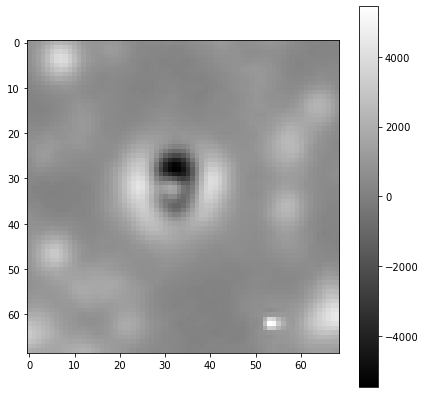

In [ ]:
import matplotlib.pyplot as plt

# Plotting the PSF model
psf_image = path_psf + '/' + image[:-5] + '_psf_residuals.fits'
psf_data = pyfits.getdata(psf_image, ext=0)
# Plot data
plt.figure(figsize=(7,7))
plt.imshow(psf_data, cmap='gray')
plt.colorbar()

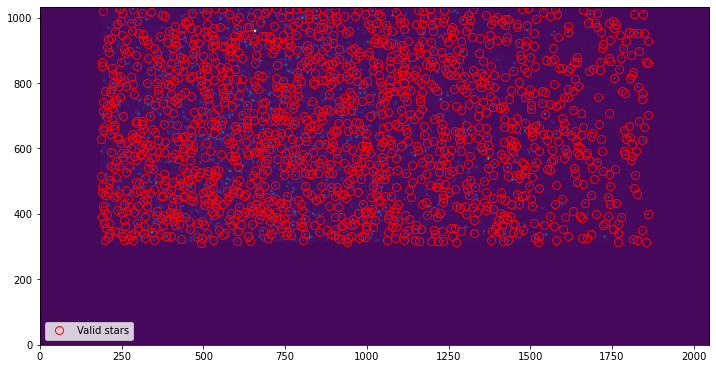

In [ ]:
# Obtain the coordinates of the extracted stars
X_stars = stars_list['X'].data
Y_stars = stars_list['Y'].data

image_data = pyfits.getdata(image_path, ext=0)
# Plot data
plt.figure(figsize=(12,12))
plt.plot(X_stars, Y_stars, 'or', mfc='none', ms=8, label='Valid stars')
plt.legend()
plt.imshow(image_data, cmap='viridis', origin='lower', vmin=100, vmax = 5000)

### 3. Matching stars (first iteration, using USNO-B1.0)

In [ ]:
# Query regions (this has to be done in the for loop of the images)
# Query the coordinates of all the stars in the image (Has to be done in RA and DEC? or I can also do it in X and Y?)
# How to know which catalogue to query? If the query returns more than one table, which one to select??
Vizier.ROW_LIMIT = -1
# Obtain the header and the dimension of the image, to query the region with the center coordinates of the image
header = pyfits.getheader(image_path)
wcs_candidate = pf.xytowcs(image_path, header['NAXIS1']/2, header['NAXIS2']/2)
# For the first iteration, query the USNO-B1 catalogue independent of the filter
try:
    filter = header['HIERARCH ESO INS FILT1 NAME']
    catalog = Vizier.query_region(coord.SkyCoord(ra=wcs_candidate[0], dec=wcs_candidate[1], unit='deg'), radius=0.1*u.deg, catalog="USNO-B1")
# Other filters?
# For now, raise an exception it the file does not have a filter, and query the USNO-B1 catalogue
except KeyError:
    catalog = catalog = Vizier.query_region(coord.SkyCoord(ra=wcs_candidate[0], dec=wcs_candidate[1], unit='deg'), radius=0.1*u.deg, catalog="USNO-B1")

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


#### Catalog alternatives found:

* GSC (2.4.2, last version): http://vizier.u-strasbg.fr/cgi-bin/VizieR-3?-source=I/353. Huge amount of different color band magnitudes, and a great amount of stars. It also has a 'Class' column, which can be used to determine if the astronomical object is a star, galaxy, etc. In fact, the class values are the following:
    * 0: Star
    * 1: Galaxy
    * 2: Blend
    * 3: Non-star
    * 4: Unclassified
    * 5: Defect


* UCAC4: https://vizier.u-strasbg.fr/viz-bin/VizieR?-source=I/322. Very similar to GSC, with less amount of stars.

Try to test in different files with different catalogs.

In [ ]:
# Extract the RA and DEC of all the stars in the table
# USNO-B1 catalog
raj = catalog[0]['RAJ2000'].data
decj = catalog[0]['DEJ2000'].data

# Obtain the x and y coordinates of the catalog stars in the image
x_test = []
y_test = []

# First matching iteration
test_image = pyfits.open(image_path)
w = WCS(test_image[0].header)

for ra, dec in zip(raj, decj):
    sky = coord.SkyCoord(ra, dec, frame='icrs', unit='deg')
    x,y = w.world_to_pixel(sky)
    x_test.append(x)
    y_test.append(y)

# Create two arrays with the coordinates of the stars, one for the catalog and one for the extracted
catalog_stars = np.c_[x_test, y_test]
extracted_stars = np.c_[X_stars, Y_stars]

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


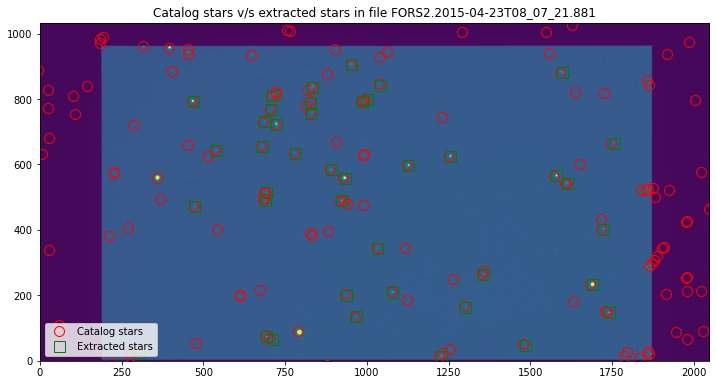

In [ ]:
image_data = pyfits.getdata(image_path, ext=0)
# Plot data
plt.figure(figsize=(12,12))
plt.plot(x_test, y_test, 'or', mfc='none', ms=10, label='Catalog stars')
plt.plot(X_stars, Y_stars, 'sg', mfc='none', ms=11, label='Extracted stars')
plt.legend(loc='lower left')
plt.title('Catalog stars v/s extracted stars in file '+image[:-5])
plt.imshow(image_data, cmap='viridis', origin='lower', vmin=100, vmax = 5000)

#### 3.1 Using KD-tree to match the stars

In [ ]:
# Using KD-tree to do the matching (with a radius threshold)

radius = 10

kd = KDTree(catalog_stars)
dd, ii = kd.query(extracted_stars, k=1, distance_upper_bound=radius)

matched_stars_kd_radius = []
matched_extracted_kd = []

for i in range(len(extracted_stars)):
    if ii[i] == len(catalog_stars):
        print(f"Extracted star {extracted_stars[i][0]}, {extracted_stars[i][1]} didn't match with any catalog star")
        continue
    print(f"Extracted star {extracted_stars[i][0]}, {extracted_stars[i][1]} matched with catalog star {catalog_stars[ii[i]]}")
    matched_extracted_kd.append(extracted_stars[i])
    matched_stars_kd_radius.append(catalog_stars[ii[i]])

matched_stars_kd_x_radius = [matched_stars_kd_radius[i][0] for i in range(len(matched_stars_kd_radius))]
matched_stars_kd_y_radius = [matched_stars_kd_radius[i][1] for i in range(len(matched_stars_kd_radius))]
extracted_kd_x = [matched_extracted_kd[i][0] for i in range(len(matched_extracted_kd))]
extracted_kd_y = [matched_extracted_kd[i][1] for i in range(len(matched_extracted_kd))]

Extracted star 301.5344, 26.9522 matched with catalog star [299.01829337  29.03264054]
Extracted star 1226.0864, 14.0855 matched with catalog star [1221.12770653   14.2916541 ]
Extracted star 951.6885, 906.1898 matched with catalog star [950.46907526 904.18019516]
Extracted star 1596.6898, 882.4611 matched with catalog star [1591.78662158  879.90133275]
Extracted star 1040.5154, 844.5538 matched with catalog star [1036.66729048  844.87889026]
Extracted star 833.5198, 837.6259 matched with catalog star [831.18410244 836.55346084]
Extracted star 709.9948, 811.275 matched with catalog star [708.15711997 809.85532818]
Extracted star 1000.4905, 800.2991 matched with catalog star [992.93196288 798.28173726]
Extracted star 467.3092, 794.0186 matched with catalog star [465.36993805 793.09409947]
Extracted star 984.4455, 795.0555 matched with catalog star [984.20716635 794.30941378]
Extracted star 825.7081, 788.3542 matched with catalog star [827.231369   795.42914372]
Extracted star 705.5645, 

In [ ]:
print(f"Number of matched stars with KD-tree and a maximum radius of {radius}: {len(matched_stars_kd_radius)}")

Number of matched stars with KD-tree and a maximum radius of 10: 41


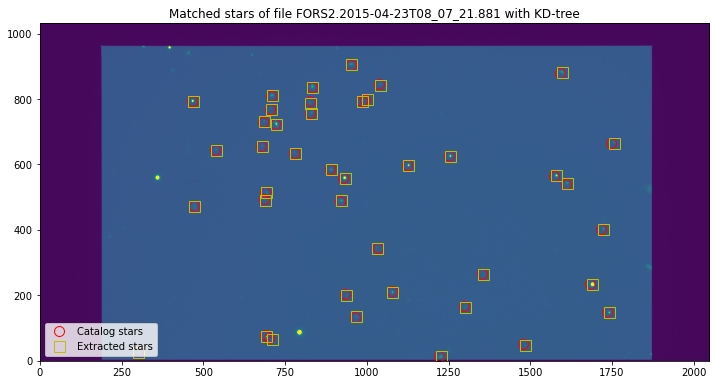

In [ ]:
image_data = pyfits.getdata(image_path, ext=0)
# Plot data
plt.figure(figsize=(12,12))
plt.plot(matched_stars_kd_x_radius, matched_stars_kd_y_radius, 'or', mfc='none', ms=10, label='Catalog stars')
plt.plot(extracted_kd_x, extracted_kd_y, 'sy', mfc='none', ms=11, label='Extracted stars')
plt.legend(loc='lower left')
plt.title('Matched stars of file '+image[:-5]+' with KD-tree')
plt.imshow(image_data, cmap='viridis', origin='lower', vmin=100, vmax = 5000)

In [ ]:
def match_stars(image_path, extracted_stars, catalog, radius):
    # Obtain the header of the image, to query the center coordinates of it
    header = pyfits.getheader(image_path)
    center = pf.xytowcs(image_path, header['NAXIS1']/2, header['NAXIS2']/2)

    # Query the given catalogue according to the filter of the image
    try:
        filter = header['HIERARCH ESO INS FILT1 NAME']
        # USNO-B1 catalog
        if catalog == 'USNO-B1':
            catalog_stars = Vizier.query_region(coord.SkyCoord(ra=center[0], dec=center[1], unit='deg'), radius=0.1*u.deg, catalog='USNO-B1')
            # Extract the RA and DEC coordinates of the catalog
            ra_values = catalog_stars[0]['RAJ2000'].data
            dec_values = catalog_stars[0]['DEJ2000'].data
        elif catalog == 'GSC':
            catalog_stars = Vizier.query_region(coord.SkyCoord(ra=center[0], dec=center[1], unit='deg'), radius=0.1*u.deg, catalog='GSC2')
            # Obtain only the stars from the catalog (i.e. the ones where Class column is equal to 0)
            catalog_stars = catalog_stars[2][catalog_stars[2]['Class'] == 0]
            #catalog_stars = catalog_stars[catalog_stars['Vmag'] >= 10]
            #catalog_stars = catalog_stars[catalog_stars['Vmag'] <= 20]
            ra_values = catalog_stars['RA_ICRS'].data
            dec_values = catalog_stars['DE_ICRS'].data
    except KeyError:
        # If the image does not have a filter, use the USNO-B1 catalog
        catalog_stars = Vizier.query_region(coord.SkyCoord(ra=center[0], dec=center[1], unit='deg'), radius=0.1*u.deg, catalog='USNO-B1')

    catalog_x = list()
    catalog_y = list()
    
    # Transform the coordinates in the catalog stars to pixel values, to query the KD-tree
    w = WCS(header)
    for ra, dec in zip(ra_values, dec_values):
        sky = coord.SkyCoord(ra, dec, frame='icrs', unit='deg')
        x, y = w.world_to_pixel(sky)
        catalog_x.append(x)
        catalog_y.append(y)

    pixel_catalog_stars = np.c_[catalog_x, catalog_y]

    # Query the KD-tree to match the extracted stars with the catalog stars in the given radius
    kd_tree = KDTree(pixel_catalog_stars)
    dd, ii = kd_tree.query(extracted_stars, k=1, distance_upper_bound=radius)

    # Create a dictionary with the matched stars, where the key is the extracted star and it's value is the index of the catalog star in the catalog
    matched_stars = {k: v for k, v in zip(range(len(extracted_stars)), ii) if v != len(pixel_catalog_stars)}

    return matched_stars

In [ ]:
# Create a dictionary with the matched stars (key: extracted star; value: index of catalog star in the catalog) to extract the magnitudes
extracted_catalog = match_stars(image_path, extracted_stars, 'USNO-B1', 10)

# Create a table with RA, DEC, X, Y, catalog Mag, flux, calculated zero point for every star
matched_stars = Table([[],[],[],[],[],[]], names=(['RA', 'DEC', 'X', 'Y', 'Catalog Mag', 'Flux']))

# Array of offsets to apply to the magnitudes
offset_array = []
zeropoint_array = []

# Array of magnitude catalogs and calculate catalogs to plot them
catalog_magnitudes = []
calculated_magnitudes = []
flux_values = []

# Array with the magnitude errors of the stars
magnitude_errors = []

header_has_filter = True
for i in extracted_catalog:
    # Obtain the RA and DEC of the matched stars in the catalog
    ra = catalog[0][extracted_catalog[i]]['RAJ2000']
    dec = catalog[0][extracted_catalog[i]]['DEJ2000']

    # Obtain the (x,y) coordinates from the star in the image
    x = extracted_stars[i][0]
    y = extracted_stars[i][1]

    # Define the extinction coefficient, and assign it depending on the filter 
    # (https://www.eso.org/observing/dfo/quality/FORS2/pipeline/coeffs.txt)
    extinction_coefficient = 0.0

    # Extract the magnitude using the appropiate filter
    try:
        filter = header['HIERARCH ESO INS FILT1 NAME']
        # Chech if the values are masked. If both are unmasked, take the mean value
        if filter == 'b_HIGH' or filter == 'v_HIGH':
            # USNO-B1 catalog
            if catalog[0][extracted_catalog[i]]['B1mag'] is not ma.masked and catalog[0][extracted_catalog[i]]['B2mag'] is not ma.masked:
                b_mag = np.mean([catalog[0][extracted_catalog[i]]['B1mag'], catalog[0][extracted_catalog[i]]['B2mag']])
            elif catalog[0][extracted_catalog[i]]['B1mag'] is ma.masked and catalog[0][extracted_catalog[i]]['B2mag'] is not ma.masked:
                b_mag = catalog[0][extracted_catalog[i]]['B2mag']
            elif catalog[0][extracted_catalog[i]]['B1mag'] is ma.masked and catalog[0][extracted_catalog[i]]['B2mag'] is ma.masked:
                continue
            else:
                b_mag = catalog[0][extracted_catalog[i]]['B1mag']
            mag_catalog = b_mag
            extinction_coefficient = 0.216
        elif filter == 'R_SPECIAL':
            if catalog[0][extracted_catalog[i]]['R1mag'] is not ma.masked and catalog[0][extracted_catalog[i]]['R2mag'] is not ma.masked:
                r_mag = np.mean([catalog[0][extracted_catalog[i]]['R1mag'], catalog[0][extracted_catalog[i]]['R2mag']])
            elif catalog[0][extracted_catalog[i]]['R1mag'] is ma.masked and catalog[0][extracted_catalog[i]]['R2mag'] is not ma.masked:
                r_mag = catalog[0][extracted_catalog[i]]['R2mag']
            else:
                r_mag = catalog[0][extracted_catalog[i]]['R1mag']
            mag_catalog = r_mag
            extinction_coefficient = 0.081
        elif filter == 'I_BESS':
            mag_catalog = catalog[0][extracted_catalog[i]]['Imag']
            extinction_coefficient = 0.059
    except KeyError:
        print("No filter found!\n")
        # Don't calculate the zeropoint (in case there is no filter)
        header_has_filter = False
        break

    # Obtain the flux performing apperture photometry for the specified coordinates 
    magstar, magerrstar, fluxstar, fluxerr, skystar, skyerrstar, badflagstar, outstrstar = \
        aper.aper(image_data, x, y, phpadu=phpadu, apr=fwhm_image, zeropoint=zeropoint_value, \
        skyrad=[skyRmin, skyRmax], badpix=[-12000, 30000], exact=True, verbose=False)

    # PSF photometry
    pk = pkfit.pkfit_class(image_data, gauss, psf_residuals_model, ronois, phpadu)
    errmag, chi, sharp, niter, scale = pk.pkfit(1, x, y, skystar, 5)

    # Compute the flux and magnitude
    flux_value = (scale*10**(0.4*(25.0-hpsf['PSFMAG'])))/(header['EXPTIME'])
    dflux_value = errmag*10**(0.4*(25.0-hpsf['PSFMAG']))
    
    mag_value = zeropoint_value-2.5*np.log10(flux_value)
    
    # Compute the zeropoint of the star using the magnitude catalog and the extinction coefficient
    airmass = np.mean([header['HIERARCH ESO TEL AIRM END'], header['HIERARCH ESO TEL AIRM START']])
    zeropoint_star = mag_catalog + 2.5*np.log10(flux_value) + (extinction_coefficient * airmass)

    # Compute the magnitude error using the error propagation equation
    # sqrt(d(mag_value)/d(flux_value)**2 * dflux_value**2)
    mag_error = np.sqrt((-1.08573/flux_value)**2 * dflux_value**2)
    magnitude_errors.append(mag_error)

    # Append the catalog and calculated magnitudes
    catalog_magnitudes.append(mag_catalog)
    calculated_magnitudes.append(mag_value)

    # Compute the offset and append it to the offset array
    offset_array.append(mag_catalog - mag_value)
    zeropoint_array.append(zeropoint_star)

    flux_values.append(flux_value)
    
# Compute the offset to apply for the zeropoint correction of the image
if header_has_filter:
    offset = np.median(offset_array)
    real_zeropoint = np.mean(zeropoint_array)

    magvalue_calibrated = magvalue + offset

# Compare the magnitude values of the stars with catalog magnitudes (and plot it)
# X axis -> catalog magnitudes ; Y axis -> calculated magnitudes with zeropoint

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


According to http://slittlefair.staff.shef.ac.uk/teaching/phy217/lectures/principles/L04/index.html, we have the following equation:

$$ m = m_0 + k \sec{z} = m_0 + kX $$ 

Where $m_0$ is the magnitude of a star observed with no extinction (above the atmosphere), and $m$ is the magnitude of a star observed at Earth's surface at zenith distance $z$.

The zeropoint is calculated as follows:

$$ zp = m + 2.5 \log_{10} F $$

We can obtain the calculated magnitude as a function of the flux value, and considering the zeropoint a constant, we have:

$$ m(f) = zp - 2.5 \log_{10} f $$

Where $m$ is the calculated magnitude and $f$ the flux obtained performing the apperture photometry.

Then:

$$\frac{dm}{df} = \frac{-1.08573}{f} $$

We have to calculate the square of that, multiply it with the squared flux error, and take the square root of all that. Then:

$$m_{err} = \sqrt{(\frac{-1.08573}{f})^2 \cdot f_{err}^2}$$

This is the error propagation equation, to calculate the magnitude errors from the flux errors.

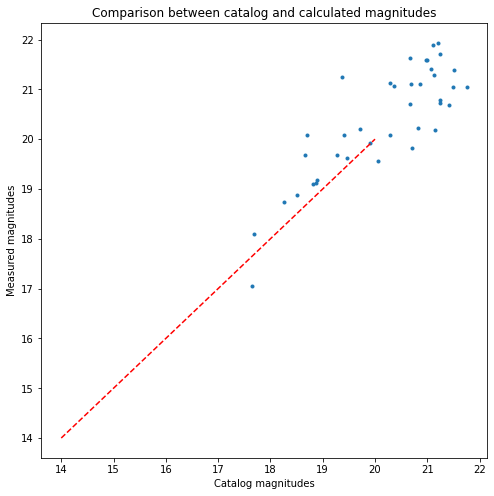

In [ ]:
# Plot the catalog and calculated magnitudes as scatter plots
plt.figure(figsize=(8,8))
plt.plot(catalog_magnitudes, calculated_magnitudes, '.')
plt.plot((14,20), (14,20), 'r--')
plt.xlabel('Catalog magnitudes')
plt.ylabel('Measured magnitudes')
plt.title('Comparison between catalog and calculated magnitudes')
plt.show()

In [ ]:
if header_has_filter:
    print("Zeropoint: ", real_zeropoint)

Zeropoint:  27.688533767770025


### 4. Astrometry

In [ ]:
extracted_stars_ra = []
extracted_stars_dec = []
catalog_stars_ra = []
catalog_stars_dec = []

for i in extracted_catalog:
    # Extracted and matched stars
    w = WCS(header)
    sky = w.pixel_to_world(extracted_stars[i][0], extracted_stars[i][1])
    extracted_stars_ra.append(sky.ra.deg)
    extracted_stars_dec.append(sky.dec.deg)
    # Catalog stars
    catalog_ra = catalog[0][extracted_catalog[i]]['RAJ2000']
    catalog_dec = catalog[0][extracted_catalog[i]]['DEJ2000']
    catalog_stars_ra.append(catalog_ra)
    catalog_stars_dec.append(catalog_dec)

ra_difference = np.array(catalog_stars_ra) - np.array(extracted_stars_ra)
dec_difference = np.array(catalog_stars_dec) - np.array(extracted_stars_dec)

ra_dec_conc = np.c_[ra_difference, dec_difference]

sigma_clipped = sigma_clip(ra_dec_conc, sigma=3, maxiters=None, masked=False, axis=(0,1))

# Remove the tuples with contains NaN values
sigma_clipped = np.asarray([t for t in sigma_clipped if not any(isinstance(n, float) and np.isnan(n) for n in t)])

sigma_clipped = sigma_clipped.flatten()

filtered_ra = sigma_clipped[::2]
filtered_dec = sigma_clipped[1::2]

filtered_data = np.c_[filtered_ra, filtered_dec]

#filtered_ra = sigma_clip(ra_difference, sigma=3, maxiters=None, masked=False)
#filtered_dec = sigma_clip(dec_difference, sigma=3, maxiters=None, masked=False)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [ ]:
print(f"Delta right ascension: {np.mean(filtered_ra)}")
print(f"Delta declination: {np.mean(filtered_dec)}")

Delta right ascension: 0.0002557346084489193
Delta declination: 9.78792287705891e-06


In [ ]:
original_data, original_header = pyfits.getdata(image_path, header=True)
astrometry_name = image[:-5] + '_astrometry.fits'

pyfits.writeto(astrometry_name, original_data, original_header, output_verify='ignore', overwrite='True')

In [ ]:
with pyfits.open(astrometry_name, 'update') as f:
    for hdu in f:
        hdu.header['CRVAL1'] += np.mean(filtered_ra)
        hdu.header['CRVAL2'] += np.mean(filtered_dec)

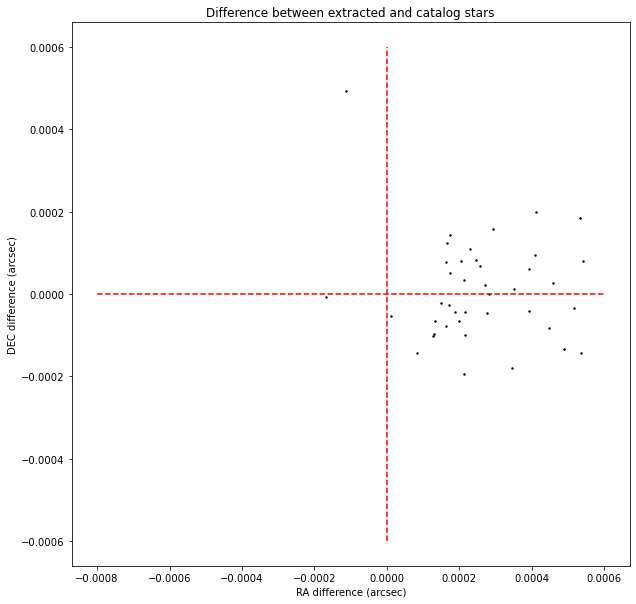

In [ ]:
# Plot the right ascension and declination difference
plt.figure(figsize=(10,10))
plt.scatter(filtered_ra, filtered_dec, s=2, c='black')
plt.plot((0, 0), (-0.0006, 0.0006), 'r--')
plt.plot((-0.0008, 0.0006), (0, 0), 'r--')
plt.xlabel('RA difference (arcsec)')
plt.ylabel('DEC difference (arcsec)')
plt.title('Difference between extracted and catalog stars')
plt.show()

### 5. Matching the stars (second iteration)

In [ ]:
# Query regions (this has to be done in the for loop of the images)
# Query the coordinates of all the stars in the image (Has to be done in RA and DEC? or I can also do it in X and Y?)
# How to know which catalogue to query? If the query returns more than one table, which one to select??
Vizier.ROW_LIMIT = -1
# Obtain the header and the dimension of the image, to query the region with the center coordinates of the image
wcs_candidate = pf.xytowcs(astrometry_name, header['NAXIS1']/2, header['NAXIS2']/2)
# Query the catalogue of bright stars according to the filter of the image
try:
    filter = header['HIERARCH ESO INS FILT1 NAME']
    catalog = Vizier.query_region(coord.SkyCoord(ra=wcs_candidate[0], dec=wcs_candidate[1], unit='deg'), radius=0.1*u.deg, catalog="GSC2")
    catalog = catalog[2][catalog[2]['Class'] == 0]
    #catalog = catalog[catalog['Vmag'] >= 10]
    #catalog = catalog[catalog['Vmag'] <= 20]
# Other filters?
# For now, raise an exception it the file does not have a filter, and query the USNO-B1 catalogue
except KeyError:
    catalog = catalog = Vizier.query_region(coord.SkyCoord(ra=wcs_candidate[0], dec=wcs_candidate[1], unit='deg'), radius=0.1*u.deg, catalog="USNO-B1")

print(catalog)

   GSC2        RA_ICRS         DE_ICRS     ...     a       e      PA 
                 deg             deg       ...    pix     pix    pix 
---------- --------------- --------------- ... --------- ------ -----
N5RD025154 221.58319163541  12.21711953488 ...        --     --    --
N5RD010842 221.60851234976  12.22117297418 ...     2.195  0.113 101.8
N5RD029240 221.55214015000  12.21743571000 ...        --     --    --
N5RD010780 221.56759535001  12.21775972927 ...     1.872  0.220 162.3
N5RD010949 221.55261230469  12.22917366028 ...     2.010  0.187  79.6
N5RD019403 221.55251070167  12.22858910880 ...        --     --    --
N5RD025150 221.57401293102  12.24170178678 ...        --     --    --
N5RD030668 221.57988953000  12.22408997000 ...        --     --    --
N5RD059907 221.52213037000  12.24651261000 ...        --     --    --
N5RD011027 221.54357018972  12.23488069389 ...     1.818  0.126 137.6
       ...             ...             ... ...       ...    ...   ...
N5W6010019 221.49908

In [ ]:
# GSC catalog
raj = catalog['RA_ICRS'].data
decj = catalog['DE_ICRS'].data

# Obtain the x and y coordinates of the catalog stars in the image
x_test = []
y_test = []

# Second matching iteration
test_image = pyfits.open(astrometry_name)
w = WCS(test_image[0].header)

for ra, dec in zip(raj, decj):
    sky = coord.SkyCoord(ra, dec, frame='icrs', unit='deg')
    x,y = w.world_to_pixel(sky)
    x_test.append(x)
    y_test.append(y)

# Create two arrays with the coordinates of the stars, one for the catalog and one for the extracted
catalog_stars = np.c_[x_test, y_test]
extracted_stars = np.c_[X_stars, Y_stars]

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [ ]:
# Using KD-tree to do the matching (with a radius threshold)

radius = 3

kd = KDTree(catalog_stars)
dd, ii = kd.query(extracted_stars, k=1, distance_upper_bound=radius)

matched_stars_kd_radius = []
matched_extracted_kd = []

for i in range(len(extracted_stars)):
    if ii[i] == len(catalog_stars):
        print(f"Extracted star {extracted_stars[i][0]}, {extracted_stars[i][1]} didn't match with any catalog star")
        continue
    print(f"Extracted star {extracted_stars[i][0]}, {extracted_stars[i][1]} matched with catalog star {catalog_stars[ii[i]]}")
    matched_extracted_kd.append(extracted_stars[i])
    matched_stars_kd_radius.append(catalog_stars[ii[i]])

matched_stars_kd_x_radius = [matched_stars_kd_radius[i][0] for i in range(len(matched_stars_kd_radius))]
matched_stars_kd_y_radius = [matched_stars_kd_radius[i][1] for i in range(len(matched_stars_kd_radius))]
extracted_kd_x = [matched_extracted_kd[i][0] for i in range(len(matched_extracted_kd))]
extracted_kd_y = [matched_extracted_kd[i][1] for i in range(len(matched_extracted_kd))]

Extracted star 301.5344, 26.9522 matched with catalog star [302.29837317  27.92481497]
Extracted star 1226.0864, 14.0855 didn't match with any catalog star
Extracted star 951.6885, 906.1898 matched with catalog star [950.92144475 903.736416  ]
Extracted star 1596.6898, 882.4611 didn't match with any catalog star
Extracted star 1040.5154, 844.5538 matched with catalog star [1040.83929063  842.40129005]
Extracted star 833.5198, 837.6259 didn't match with any catalog star
Extracted star 709.9948, 811.275 matched with catalog star [711.45757859 810.86142032]
Extracted star 1000.4905, 800.2991 matched with catalog star [1000.77648535  798.30842094]
Extracted star 467.3092, 794.0186 matched with catalog star [469.10649588 792.61460231]
Extracted star 984.4455, 795.0555 matched with catalog star [984.72407294 793.17433964]
Extracted star 825.7081, 788.3542 didn't match with any catalog star
Extracted star 705.5645, 770.9369 didn't match with any catalog star
Extracted star 830.5695, 758.8964 

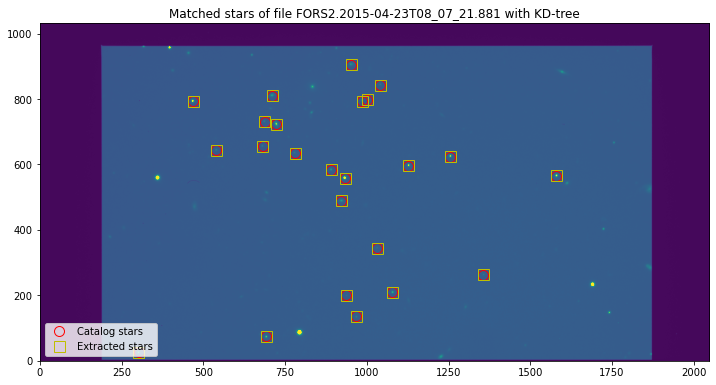

In [ ]:
image_data = pyfits.getdata(astrometry_name, ext=0)
# Plot data
plt.figure(figsize=(12,12))
plt.plot(matched_stars_kd_x_radius, matched_stars_kd_y_radius, 'or', mfc='none', ms=10, label='Catalog stars')
plt.plot(extracted_kd_x, extracted_kd_y, 'sy', mfc='none', ms=11, label='Extracted stars')
plt.legend(loc='lower left')
plt.title('Matched stars of file '+image[:-5]+' with KD-tree')
plt.imshow(image_data, cmap='viridis', origin='lower', vmin=100, vmax = 5000)

In [ ]:
astrometry_stars = match_stars(astrometry_name, extracted_stars, 'GSC', 3)

# Array of offsets to apply to the magnitudes
offset_array = []
zeropoint_array = []

# Array of magnitude catalogs and calculate catalogs to plot them
catalog_magnitudes = dict()
calculated_magnitudes = dict()
flux_values = []

# Array with the magnitude errors of the stars
magnitude_errors = dict()

header_has_filter = True
for i in astrometry_stars:
    # Obtain the RA and DEC of the matched stars in the catalog

    # GSC catalog
    ra = catalog[astrometry_stars[i]]['RA_ICRS']
    dec = catalog[astrometry_stars[i]]['DE_ICRS']

    # Obtain the (x,y) coordinates from the star in the image
    x = extracted_stars[i][0]
    y = extracted_stars[i][1]

    # Define the extinction coefficient, and assign it depending on the filter 
    # (https://www.eso.org/observing/dfo/quality/FORS2/pipeline/coeffs.txt)
    extinction_coefficient = 0.0

    header = pyfits.getheader(astrometry_name)

    # Extract the magnitude using the appropiate filter
    try:
        filter = header['HIERARCH ESO INS FILT1 NAME']
        # Chech if the values are masked. If both are unmasked, take the mean value
        if filter == 'b_HIGH':
            # GSC catalog
            if catalog[astrometry_stars[i]]['Bmag'] is ma.masked:
                print(f"Invalid magnitude for star {i}")
                continue
            mag_catalog = catalog[astrometry_stars[i]]['Bmag']
            extinction_coefficient = 0.216
        elif filter == 'R_SPECIAL':
            if catalog[astrometry_stars[i]]['rmag'] is ma.masked:
                print(f"Invalid magnitude for star {i}")
                continue
            mag_catalog = catalog[astrometry_stars[i]]['rmag']
            extinction_coefficient = 0.081
        elif filter == 'I_BESS':
            if catalog[astrometry_stars[i]]['imag'] is ma.masked:
                #print(f"Invalid magnitude for star {i}")
                continue
            mag_catalog = catalog[astrometry_stars[i]]['imag']
            extinction_coefficient = 0.059
        elif filter == 'v_HIGH':
            zeropoint_value = 28.2
            mag_catalog = 1.0
            extinction_coefficient = 0.118
    except KeyError:
        print("No filter found!\n")
        # Don't calculate the zeropoint (in case there is no filter)
        header_has_filter = False
        break

    # Obtain the flux performing apperture photometry for the specified coordinates 
    magstar, magerrstar, fluxstar, fluxerr, skystar, skyerrstar, badflagstar, outstrstar = \
        aper.aper(image_data, x, y, phpadu=phpadu, apr=fwhm_image, zeropoint=zeropoint_value, \
        skyrad=[skyRmin, skyRmax], badpix=[-12000, 30000], exact=True, verbose=False)

    # PSF photometry
    pk = pkfit.pkfit_class(image_data, gauss, psf_residuals_model, ronois, phpadu)
    errmag, chi, sharp, niter, scale = pk.pkfit(1, x, y, skystar, 5)

    # Compute the flux and magnitude
    flux_value = (scale*10**(0.4*(25.0-hpsf['PSFMAG'])))/(header['EXPTIME'])
    dflux_value = errmag*10**(0.4*(25.0-hpsf['PSFMAG']))
    
    mag_value = zeropoint_value-2.5*np.log10(flux_value)
    
    # Compute the zeropoint of the star using the magnitude catalog and the extinction coefficient
    airmass = np.mean([header['HIERARCH ESO TEL AIRM END'], header['HIERARCH ESO TEL AIRM START']])
    zeropoint_star = mag_catalog + 2.5*np.log10(flux_value) + (extinction_coefficient * airmass)

    # Compute the magnitude error using the error propagation equation
    # sqrt(d(mag_value)/d(flux_value)**2 * dflux_value**2)
    mag_error = np.sqrt((-1.08573/flux_value)**2 * dflux_value**2)
    magnitude_errors[i] = mag_error

    # Append the catalog and calculated magnitudes
    catalog_magnitudes[i] = mag_catalog
    calculated_magnitudes[i] = mag_value

    # Compute the offset and append it to the offset array
    offset_array.append(mag_catalog - mag_value)
    zeropoint_array.append(zeropoint_star)

    flux_values.append(flux_value)
    
# Compute the offset to apply for the zeropoint correction of the image
if header_has_filter:
    offset = np.median(offset_array)
    if filter == 'v_HIGH':
        real_zeropoint = 28.2
    else:
        real_zeropoint = np.mean(zeropoint_array)

    magvalue_calibrated = magvalue + offset

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


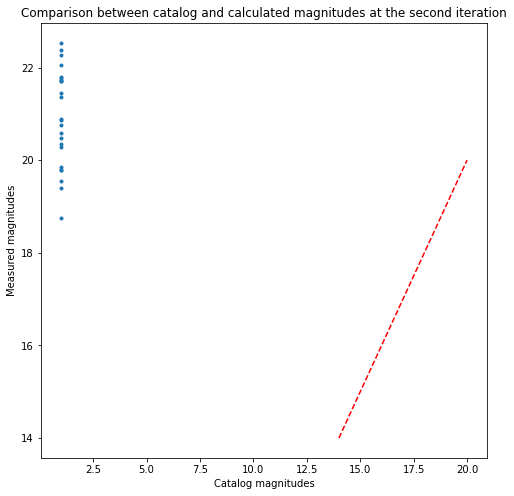

In [ ]:
# Plot the catalog and calculated magnitudes as scatter plots
plt.figure(figsize=(8,8))
plt.plot(catalog_magnitudes.values(), calculated_magnitudes.values(), '.')
plt.plot((14,20), (14,20), 'r--')
plt.xlabel('Catalog magnitudes')
plt.ylabel('Measured magnitudes')
plt.title('Comparison between catalog and calculated magnitudes at the second iteration')
plt.show()

In [ ]:
if header_has_filter:
    print("Zeropoint: ", real_zeropoint)

Zeropoint:  28.2


In [ ]:
# Create a table with the extracted stars after astrometry
astrometry_table = Table([[],[]], names=('X', 'Y'))

extracted_keys = [k for k in astrometry_stars.keys()]
for i in range(len(astrometry_stars)):
    astrometry_table.add_row([extracted_stars[extracted_keys[i]][0], extracted_stars[extracted_keys[i]][1]])

In [ ]:
fwhm_psf_2 = []
ellipticity_psf_2 = []

# Get dimension of the image
x_dim = int(len(data_image[0]))
y_dim = int(len(data_image))

# Computing the FWHM and ellipticity of every star using PSF fitting
for i in range(len(astrometry_stars)):
    star = astrometry_table[i]
    # Check that the star is located within acceptable values (not too close to the borders)
    checklocation = (star['X'] > 2.5*fwhm_nominal and star['X'] < (x_dim-2.5*fwhm_nominal) and  star['Y'] > 2.5*fwhm_nominal and star['Y'] < (y_dim-2.5*fwhm_nominal))
    if not checklocation:
        print(f"Star #{i} too close to the borders, skipping...")   
        continue
    # PSF of the image using a single star (star #i)
    gauss, psf_residuals, psfmag = pf.getPSFimage(data_image, image_path, star, star['X'], star['Y'], ronois, phpadu, individual=True, pathpsf=path_psf)
    
    # Error, no convergence for the star
    if np.array_equal(gauss, np.array([-1,-1,-1,-1,-1])):
        continue
    
    # Compute the FWHM
    sigma_star = np.mean([gauss[3], gauss[4]])
    fwhm_star = 2.355*sigma_star
    fwhm_psf_2.append(fwhm_star)

    # Obtain the header of the PSF model generated
    hpsf = pyfits.getheader(path_psf + '/' + image[:-5] + '_psf_residuals.fits')
    # Determine the semi major and semi minor axis to obtain the ellipticity
    direction_x = hpsf['GAUSS4']
    direction_y = hpsf['GAUSS5']

    ellipticity_star = 0.0

    # Compute the ellipticity using the sextractor formula (1 - (semiminor axis)/(semimajor axis))
    if direction_x >= direction_y:
        ellipticity_star = 1 - (direction_y)/(direction_x)
    else:
        ellipticity_star = 1 - (direction_x)/(direction_y)

    ellipticity_psf_2.append(ellipticity_star)

(array([0]),)
mag:  [12.66440626]
(array([0]),)
mag:  [12.6148081]
No convergence after 100 iterations for star 0
(array([0]),)
mag:  [14.06177232]
(array([0]),)
mag:  [12.48615915]
(array([0]),)
mag:  [14.93081162]
(array([0]),)
mag:  [11.72283525]
(array([0]),)
mag:  [13.36972902]
(array([0]),)
mag:  [11.69811491]


(array([0]),)
mag:  [13.99829554]
(array([0]),)
mag:  [14.14033567]
(array([0]),)
mag:  [13.78359905]
(array([0]),)
mag:  [14.03728824]
(array([0]),)
mag:  [12.1388945]
(array([0]),)
mag:  [12.10250017]
(array([0]),)
mag:  [13.20460282]
(array([0]),)
mag:  [11.87347728]
(array([0]),)
mag:  [11.08167751]
(array([0]),)
mag:  [12.65852524]
(array([0]),)
mag:  [14.52585207]
(array([0]),)
mag:  [14.38669427]
(array([0]),)
mag:  [12.83286685]
(array([0]),)
mag:  [14.67967686]
(array([0]),)
mag:  [14.02533622]
(array([0]),)
mag:  [12.59200461]


In [ ]:
print(f"Average FWHM (first iteration): {np.mean(fwhm_psf)}, (second iteration): {np.mean(fwhm_psf_2)}(PSF) | {np.mean(fwhm_sextractor)} (Sextractor)")
print(f"Median FWHM (first iteration): {np.median(fwhm_psf)}, (second iteration): {np.median(fwhm_psf_2)} (PSF) | {np.median(fwhm_sextractor)} (Sextractor)")
print(f"Average ellipticity (first iteration): {np.mean(ellipticity_psf)}, (second iteration): {np.mean(ellipticity_psf_2)} (PSF) | {np.mean(ellipticity_sextractor)} (Sextractor)")
print(f"Median ellipticity (first iteration): {np.median(ellipticity_psf)}, (second iteration): {np.median(ellipticity_psf_2)} (PSF) | {np.median(ellipticity_sextractor)} (Sextractor)")

Average FWHM (first iteration): 5.262330673185107, (second iteration): 4.725929210249799(PSF) | 5.769024390243903 (Sextractor)
Median FWHM (first iteration): 4.556059380809497, (second iteration): 4.478662476137043 (PSF) | 4.55 (Sextractor)
Average ellipticity (first iteration): 0.07245921380370995, (second iteration): 0.05849842281165274 (PSF) | 0.14482926829268294 (Sextractor)
Median ellipticity (first iteration): 0.044506683234084465, (second iteration): 0.040802258656716606 (PSF) | 0.085 (Sextractor)


* Sextract the fainter stars of images with high exposure times (60 seconds)
* Calculate the magnitudes of the stars based in the PSF fitting of the bright ones 
* Make a histogram of the magnitudes of the stars

### 6. Exposure times measurement

In [ ]:
fors2_table = pd.read_csv('wdb_query_3461_eso.csv')

In [ ]:
fors2_table.head(10)

,Release Date,Object,RA,DEC,Target Ra Dec,Target l b,EXPTIME,INS.FILT1.NAME,INS.FILT2.NAME,DET.WIN1.NY..
0,2015-01-01,"FLAT,SKY",12.738159,-27.77562,00:50:57.16 -27:46:32.2,312.349534 -89.343820,2.466,u_HIGH,NaN,2048.0
1,2015-01-01,"FLAT,SKY",12.738159,-27.77562,00:50:57.16 -27:46:32.2,312.349534 -89.343820,2.466,u_HIGH,NaN,2048.0
2,2015-01-01,"FLAT,SKY",12.741296,-27.77284,00:50:57.91 -27:46:22.2,312.149453 -89.347015,2.852,u_HIGH,NaN,2048.0
3,2015-01-01,"FLAT,SKY",12.741296,-27.77284,00:50:57.91 -27:46:22.2,312.149453 -89.347015,2.852,u_HIGH,NaN,2048.0
4,2015-01-01,"FLAT,SKY",12.744434,-27.77006,00:50:58.66 -27:46:12.2,311.947317 -89.350202,3.207,u_HIGH,NaN,2048.0
5,2015-01-01,"FLAT,SKY",12.744434,-27.77006,00:50:58.66 -27:46:12.2,311.947317 -89.350202,3.207,u_HIGH,NaN,2048.0
6,2015-01-01,"FLAT,SKY",12.747571,-27.76728,00:50:59.42 -27:46:02.2,311.743256 -89.353380,3.561,u_HIGH,NaN,2048.0
7,2015-01-01,"FLAT,SKY",12.747571,-27.76728,00:50:59.42 -27:46:02.2,311.743256 -89.353380,3.561,u_HIGH,NaN,2048.0
8,2015-01-01,"FLAT,SKY",12.750709,-27.76451,00:51:00.17 -27:45:52.2,311.536955 -89.356541,3.995,u_HIGH,NaN,2048.0
9,2015-01-01,"FLAT,SKY",12.750709,-27.76451,00:51:00.17 -27:45:52.2,311.536955 -89.356541,3.995,u_HIGH,NaN,2048.0


In [ ]:
b_exposure_times = fors2_table.loc[fors2_table['INS.FILT1.NAME'] == 'b_HIGH']['EXPTIME'].to_numpy()
r_exposure_times = fors2_table.loc[fors2_table['INS.FILT1.NAME'] == 'R_SPECIAL']['EXPTIME'].to_numpy()
i_exposure_times = fors2_table.loc[fors2_table['INS.FILT1.NAME'] == 'I_BESS']['EXPTIME'].to_numpy()
v_exposure_times = fors2_table.loc[fors2_table['INS.FILT1.NAME'] == 'v_HIGH']['EXPTIME'].to_numpy()

In [ ]:
# Remove all zeros and nan values from the arrays
b_exposure_times = b_exposure_times[(b_exposure_times != 0) & (~np.isnan(b_exposure_times))]
r_exposure_times = r_exposure_times[(r_exposure_times != 0) & (~np.isnan(r_exposure_times))]
i_exposure_times = i_exposure_times[(i_exposure_times != 0) & (~np.isnan(i_exposure_times))]
v_exposure_times = v_exposure_times[(v_exposure_times != 0) & (~np.isnan(v_exposure_times))]

# Extract the values less or equal than 500
b_exposure_times = [x for x in b_exposure_times if x < 61 and x > 50]
r_exposure_times = [x for x in r_exposure_times if x < 61 and x > 50]
i_exposure_times = [x for x in i_exposure_times if x < 61 and x > 50]
v_exposure_times = [x for x in v_exposure_times if x < 61 and x > 50]

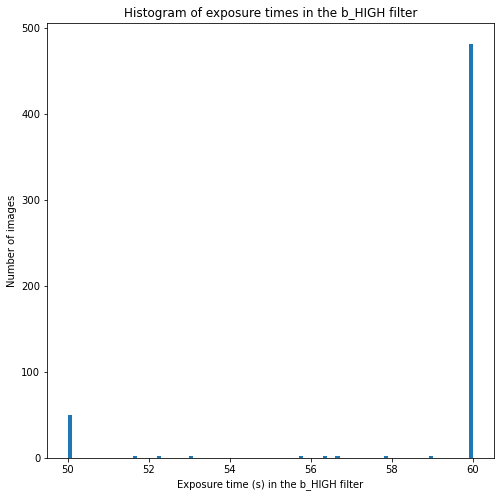

In [ ]:
plt.figure(figsize=(8,8))
plt.hist(b_exposure_times, bins=100)
plt.xlabel('Exposure time (s) in the b_HIGH filter')
plt.ylabel('Number of images')
plt.title('Histogram of exposure times in the b_HIGH filter')
plt.show()

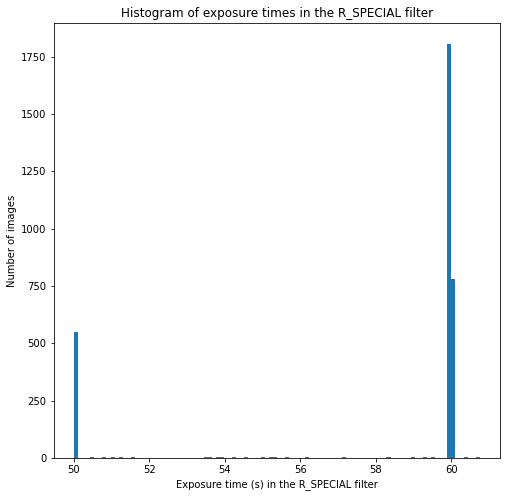

In [ ]:
plt.figure(figsize=(8,8))
plt.hist(r_exposure_times, bins=100)
plt.xlabel('Exposure time (s) in the R_SPECIAL filter')
plt.ylabel('Number of images')
plt.title('Histogram of exposure times in the R_SPECIAL filter')
plt.show()

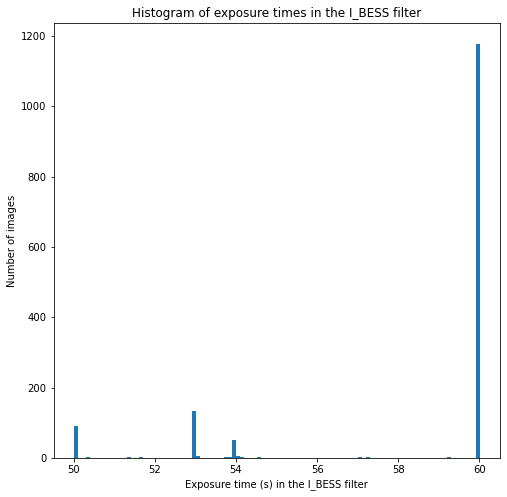

In [ ]:
plt.figure(figsize=(8,8))
plt.hist(i_exposure_times, bins=100)
plt.xlabel('Exposure time (s) in the I_BESS filter')
plt.ylabel('Number of images')
plt.title('Histogram of exposure times in the I_BESS filter')
plt.show()

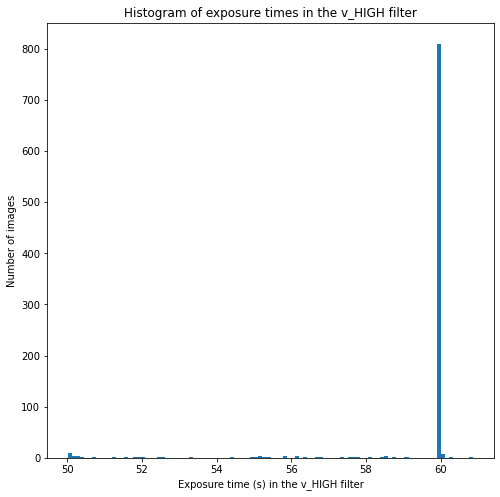

In [ ]:
plt.figure(figsize=(8,8))
plt.hist(v_exposure_times, bins=100)
plt.xlabel('Exposure time (s) in the v_HIGH filter')
plt.ylabel('Number of images')
plt.title('Histogram of exposure times in the v_HIGH filter')
plt.show()

In [ ]:
def write_results(image):
    # Directory of the result of the image
    current_directory = os.getcwd()
    image_directory = os.path.join(current_directory + '/results', r'{}'.format(image[:-5]))

    # Path of the actual image
    image_path = os.path.join(fors2_folder, image)

    # Obtain the header of the image
    header = pyfits.getheader(image_path)

    # Create the file which will contain the results
    with open(image_directory + '/results.txt', 'w') as f:
        # First line of the results file contain the following:
        # Filter, Avg FWHM, Median FWHM, Avg ellipticity, Median ellipticity (Sextractor, PSF, in that order), Zeropoint
        # Rest of the lines contain the following, for every star detected with Sextractor:
        # X, Y, RA, DEC, Flux, Fluxerr, Catalog Mag, RA Cat, DEC Cat, PSF Mag, PSF Mag err
        f.write("{},{},{},{},{},{},{},{},{},{}\n".format(header['HIERARCH ESO INS FILT1 NAME'],\
            average_fwhm_sextractor, median_fwhm_sextractor, average_ellipticity_sextractor,\
            median_ellipticity_sextractor, average_fwhm_psf, median_fwhm_psf, average_ellipticity_psf,\
            median_ellipticity_psf, real_zeropoint))

    # Create the file which will contain the different values of star features
    table_to_file.write(image_directory + '/results_stars.txt', format='ascii', delimiter=',')

#### File formatting for the results

In [ ]:
stars_list.remove_columns(['ellipticity', 'mag', 'fwhm'])
ra_table, dec_table = pf.xytowcs(image_path, stars_list['X'], stars_list['Y'])

# Add the stars matched in the 2nd iteration, with it's catalog magnitude, RA and DEC
catalog_magnitudes_tables = list()
catalog_ra_table = list()
catalog_dec_table = list()
psf_magnitudes = list()
psf_magnitudes_error = list()

for i in range(len(extracted_stars)):
    if i in astrometry_stars and i in calculated_magnitudes:
        # Add the RA and DEC values of the matched star in the catalog
        catalog_ra_table.append(catalog[astrometry_stars[i]]['RA_ICRS'])
        catalog_dec_table.append(catalog[astrometry_stars[i]]['DE_ICRS'])
        # Add the catalog magnitude value of the matched star
        catalog_magnitudes_tables.append(catalog_magnitudes[i])
        # Add the PSF calculated magnitude and magnitude error
        psf_magnitudes.append(calculated_magnitudes[i])
        psf_magnitudes_error.append(magnitude_errors[i])
        
    else:
        catalog_ra_table.append(None)
        catalog_dec_table.append(None)
        catalog_magnitudes_tables.append(None)
        psf_magnitudes.append(None)
        psf_magnitudes_error.append(None)

# Columns names
stars_list['RA'] = ra_table
stars_list['DEC'] = dec_table
stars_list['Mag_CAT'] = catalog_magnitudes_tables
stars_list['RA_CAT'] = catalog_ra_table
stars_list['DEC_CAT'] = catalog_dec_table
stars_list['Mag_PSF'] = psf_magnitudes
stars_list['Mag_PSF_err'] = psf_magnitudes_error

# Columns order
column_order = ['X', 'Y', 'RA', 'DEC', 'flux', 'fluxerr', 'Mag_CAT', 'RA_CAT', 'DEC_CAT', 'Mag_PSF', 'Mag_PSF_err']
table_to_file = stars_list[column_order]

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [ ]:
write_results(image)

In [ ]:
# <sigmas> or <threshold>,<ZP> in mag.arcsec-2, to detect fainter sources
detect_thresh = 1.5

# Extract all the stars from the image using Sextractor
os.system('sex ' + image_path + ' -DETECT_THRESH ' + str(detect_thresh) + ' -CATALOG_NAME ' + image[:-5] + '.sex2d.txt')

# Create the directory which will contain all the Sextractor related files with the name of the image
current_directory = os.getcwd()
image_directory = os.path.join(current_directory + '/results', r'{}'.format(image[:-5]))

valid_stars, total_stars = create_valid_stars(image)

print(f'Number of valid stars, i.e. stars with flag value 0: {valid_stars}')
print(f'Number of total stars: {total_stars}')
print(f'Percentage of valid stars: {valid_stars/total_stars*100}%')

# Read the list of coordinates obtained with sextractor for the given image, which flag values are 0 (i.e. not saturated stars)
stars_file = image_directory + "/" + image[:-5] + '.sex2d.valid.txt' 
stars_list = Table.read(stars_file, format='ascii', delimiter=' ')
# Rename the first 3 columns, as index, X coordinate and Y coordinate. The starlist has another parameters, but for now they are not important
# Also rename the 5th column, because the flux is important to filter bright and faint stars
stars_list.rename_column('col1','ID')
stars_list.rename_column('col2','X')
stars_list.rename_column('col3','Y')
stars_list.rename_column('col5', 'flux')
stars_list.rename_column('col6', 'fluxerr')

# Define the header and data of the image
image_data = pyfits.getdata(image_path, ext=0)
image_header = pyfits.getheader(image_path, ext=0)

# Array which contains the measured magnitudes of the stars
measured_magnitudes = list()
magnitude_errors = list()

for x, y in zip(stars_list['X'], stars_list['Y']):
    # Obtain the flux performing apperture photometry for the specified coordinates 
    magstar, magerrstar, fluxstar, fluxerr, skystar, skyerrstar, badflagstar, outstrstar = \
        aper.aper(image_data, x, y, phpadu=phpadu, apr=fwhm_image, zeropoint=real_zeropoint, \
        skyrad=[skyRmin, skyRmax], badpix=[-12000, 30000], exact=True, verbose=False)

    # PSF photometry
    pk = pkfit.pkfit_class(image_data, gauss, psf_residuals_model, ronois, phpadu)
    errmag, chi, sharp, niter, scale = pk.pkfit(1, x, y, skystar, 5)

    # Compute the flux and magnitude
    flux_value = (scale*10**(0.4*(25.0-hpsf['PSFMAG'])))/(header['EXPTIME'])
    dflux_value = errmag*10**(0.4*(25.0-hpsf['PSFMAG']))
    
    mag_value = real_zeropoint-2.5*np.log10(flux_value)

    # Compute the magnitude error
    mag_error = np.sqrt((-1.08573/flux_value)**2 * dflux_value**2)

    # Append the measured magnitude to the list
    measured_magnitudes.append(mag_value)
    magnitude_errors.append(mag_error)


> WARNING: NTHREADS != 1 ignored: this build of SExtractor is single-threaded

> 
----- SExtractor 2.19.5 started on 2022-03-21 at 16:13:12 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing catalog
> Looking for FORS2.2015-04-23T08_07_21.881.fits
----- Measuring from: FORS2.2015-04-23T08_07_21.881.fits
      "RRM GRB" / no ext. header / 2048x1034 / 16 bits (integers)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line:  256
> Setting up background map at line:  320
> Setting up background map at line:  384
> Setting up background map at line:  448
> Setting up background map at line:  512
> Setting up background map at line:  576
> Setting up background map at line:  640
> Setting up background map at line:  704
> Setting up background map at line:  768
> Setting up background map at 

Number of valid stars, i.e. stars with flag value 0: 155
Number of total stars: 278
Percentage of valid stars: 55.75539568345324%


In [ ]:
stars_list.remove_columns(['col4', 'col7', 'col8'])
ra_table, dec_table = pf.xytowcs(image_path, stars_list['X'], stars_list['Y'])
# Add the RA and DEC values of the stars in the table
stars_list['RA'] = ra_table
stars_list['DEC'] = dec_table
# Add the measured magnitudes and magnitude errors to the table
stars_list['Mag_PSF'] = measured_magnitudes
stars_list['Mag_PSF_err'] = magnitude_errors

# Columns order
column_order = ['X', 'Y', 'RA', 'DEC', 'flux', 'fluxerr', 'Mag_PSF', 'Mag_PSF_err']
table_to_file = stars_list[column_order]

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [ ]:
table_to_file.write(image_directory + '/results_faint.txt', format='ascii', delimiter=',')

In [ ]:
""" flatten_combined_magnitudes = [item for sublist in combined_magnitudes for item in sublist]

# Do an histogram of the measured magnitudes
plt.figure(figsize=(8,8))
plt.hist(flatten_combined_magnitudes, bins=100)
plt.xlabel('Measured magnitude')
plt.ylabel('Number of stars')
plt.title('Histogram of measured magnitudes (b_HIGH filter)')
plt.show() """

" flatten_combined_magnitudes = [item for sublist in combined_magnitudes for item in sublist]\n\n# Do an histogram of the measured magnitudes\nplt.figure(figsize=(8,8))\nplt.hist(flatten_combined_magnitudes, bins=100)\nplt.xlabel('Measured magnitude')\nplt.ylabel('Number of stars')\nplt.title('Histogram of measured magnitudes (b_HIGH filter)')\nplt.show() "

In [ ]:
# Delete all files that end with '.sex2d.txt' and with '_astrometry.fits'
for file in os.listdir(os.getcwd()):
    if file.endswith('.sex2d.txt') or file.endswith('_astrometry.fits'):
        os.remove(file)

In [ ]:
print(f"PSF fit for image {image[:-5]} gives magnitude {magvalue_calibrated} +/- {magerror}")
print(f"PSF fit for image {image[:-5]} gives flux {fluxx} +/- {dflux}")

PSF fit for image FORS2.2015-04-23T08_07_21.881 gives magnitude -2.8484575731355655 +/- 0.7596761490039015
PSF fit for image FORS2.2015-04-23T08_07_21.881 gives flux 16009.391102655225 +/- 8056.8787058864855


According to http://dc.zah.uni-heidelberg.de/tableinfo/usnob.data, we have the following magnitudes (for USNO-B1 catalog):

* **B1mag**: First blue magnitude (B1)
* **B2mag**: Second blue magnitude (B2)
* **R1mag**: First red magnitude (R1)
* **R2mag**: Second red magnitude (R2)
* **Imag**: Infrared (N) magnitude

Also, according to http://archive.eso.org/bin/qc1_cgi?action=qc1_browse_table&table=fors2_photometry, we have the following filters:

* **I_BESS**
* **R_SPECIAL**
* **b_HIGH**
* **v_HIGH**

<center>
<img src="./Images/FORS2filters.png" width=600px>
<p> Source: FORS2 User Manual </p>
</center>

Then, the relationship between the filter and the catalog magnitudes should be:

* **I_BESS** -> **Imag**
* **R_SPECIAL** -> **R1mag** and **R2mag**
* **b_HIGH** -> **B1mag** and **B2mag**
* **v_HIGH** -> Use NOMAD Catalog and use Vmag

TODO:

* Test on different files with *exptime* > 100 seconds
* Store the results in a log file
* If the filter of the file is v_HIGH, change the stars catalog to NOMAD instead of USNO-B1
* Code cleanup (variable names, documentation, etc.)
* Maintain the code in Jupyter Notebook or in a .py file?
* Upload it to GitHub/Gitlab?